# Setup:

In [179]:
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer
from string import punctuation

# Load experiment data
filename = '../data/pilot-classElicitation-free-3/class-elicitation-free-3-trials.csv'
df = pd.read_csv(filename)

# Count unique NPs
unique_nps = df['np'].append(df['response']).drop_duplicates().to_frame()
unique_nps.columns = ['np']
unique_nps.index = unique_nps['np']

print('Number of unique NPs (including responses):', len(unique_nps))


# Load word embedding data
filename_with_sim = 'word-sim:08-14-15:34.csv'
sim_df = pd.read_pickle(filename_with_sim).drop(columns = ['np'])
sim_df['vec'] = sim_df['vec'].apply(lambda x: x.detach().numpy())


# Remove out-of-vocab words
vec_length = len(sim_df.iat[0, 0])
has_embedding = sim_df['vec'].apply(lambda x: (x != np.zeros(vec_length)).any())

sim_df[has_embedding].head(5)


Number of unique NPs (including responses): 496


,vec
np,
rooster,"[0.34423, 0.51608, 0.20358, -0.93498, -0.27183..."
fruit,"[-0.86569, 0.48033, -0.39666, -0.025072, 0.441..."
gymnasium,"[1.1481, 0.78332, -0.37319, 0.47038, -0.84209,..."
giraffe,"[0.41473, 0.31884, 0.54587, -0.096985, -0.0133..."
apartment,"[0.98493, -0.13416, 0.25951, 0.35468, -0.05933..."


# Preprocessing

In [180]:
# Did they fail the memory check?
memory_check_file = '../data/pilot-classElicitation-free-3/class-elicitation-free-3-catch_trials.csv'
memory_check_df = pd.read_csv(memory_check_file)[['workerid', 'correct']]

passed_memory_check = memory_check_df.groupby(['workerid']).sum() >= 8

df = pd.merge(df, passed_memory_check, on = ['workerid'], how = 'left')
df = df[df['correct'] == True].drop(columns = ['correct'])



# lemmatizer = WordNetLemmatizer()

# def process_response_group(responses, lemmatizer):

#     responses_lemmatized = []
#     for r in responses:
#         # remove leading/trailing spaces
#         r = r.strip()
#         # remove trailing punctuation
#         r = r.rstrip(punctuation)
#         responses_lemmatized.append(lemmatizer.lemmatize(r))
#     response_freqs = Counter(responses_lemmatized).most_common()
#     return response_freqs

# Querying Word Embeddings

## Gensim (deprecated)

In [9]:
import gensim.downloader as api
import numpy as np

def compute_sim_GENSIM(row, model, word1, word2):
    try:
        return model.similarity(row[word1], row[word2])
    except KeyError as e:
        return np.nan

def compute_similarities_GENSIM(data, x, y, model_names, save = True):
    ''' Given a pandas dataframe, compute the similarity between the words in two columns.
        A new data frame is returned that is a duplicate of the original but also contains
        columns for word similarity.

        Note: If either word in a given row does not exist in the word embedding, similarity cannot be computed
        and np.nan (not a number) is returned.

        Keyword arguments:
        data -- the pandas dataframe
        x -- the name of the first column of words
        y -- the name of the second column of words
        model_names -- a list of gensim model names that should be used to compute similarity,
                        each model will add a new column to the dataframe
                        * See https://github.com/RaRe-Technologies/gensim-data for more info on model names
        save -- Boolean representing if the dataframe should be saved to HDD as a csv file, Defaults to True
    '''
    import gensim.downloader as api

    for model_name in model_names:

        # load the model and give it a proper name in the data-frame
        model = api.load(model_name)
        name = 'sim_' + model_name.split('-')[0]

        # compute the similarity between stim and response
        data[name] = data.apply(lambda row: compute_sim_GENSIM(row, model, x, y), axis=1)

        print(name, 'has completed!')


    # models take a lot of time to compute, so save to csv each time
    if save:
        save_file = 'with-model:' + time.strftime("%m-%d-%H:%M") + '.csv'
        data.to_csv(save_file, encoding='utf-8', index=False)

    return data

# No longer using gensim!
# compute_similarities_GENSIM(df, 'np', 'response', model_names = ['glove-wiki-gigaword-100'], save = True)

## Flair Document Embedding (computed on Openmind)

In [10]:
def get_word_vector(word, model, norm = False):
    try:
        vec = sim_df.at[word, model]

        if norm:
            vec = vec / np.linalg.norm(vec)
        
    except KeyError:
        vec = np.nan
        
    return vec


def append_similarity(data, x = 'np', y = 'response', add_raw_vectors = False):
    ''' Given a pandas dataframe, compute the similarity between the words in two columns.
        A new data frame is returned that is a duplicate of the original but also contains
        columns for word similarity.

        Note: If either word in a given row does not exist in the word embedding, similarity cannot be computed
        and np.nan (not a number) is returned.

        Keyword arguments:
        data -- the pandas dataframe
        x -- the name of the first column of words
        y -- the name of the second column of words
        model  -- 'glove' or fasttext
    '''
    
     # Compute the normalized vector for each word
    stim_vec = data[x].map(lambda x: get_word_vector(x, 'vec', norm = True))
    response_vec = data[y].map(lambda x: get_word_vector(x, 'vec', norm = True)) 
    
    embedding = pd.concat([stim_vec, response_vec], axis=1)
    
   
    if add_raw_vectors:
        data = data.assign(stim_vector = stim_vec,
                           response_vector = response_vec)

            
    # Compute the cosine similarity
    data['similarity'] = embedding.apply(lambda row: np.dot(row[x], row[y]), axis = 1)
    
    return data

# Understanding Similarities

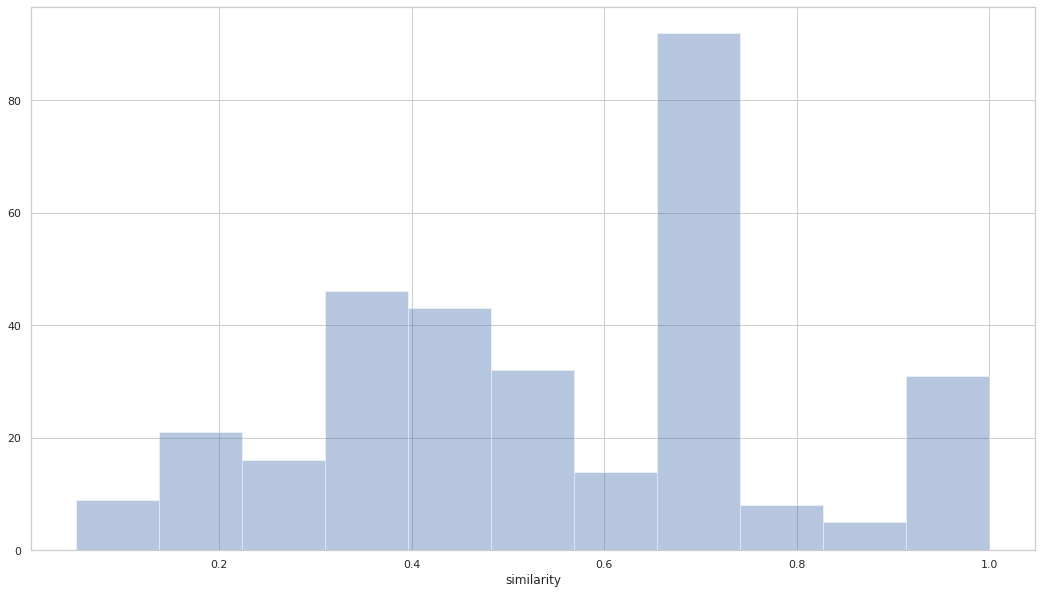

In [181]:
# Plot with/without hue
sns.set(style = 'whitegrid')

fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(18, 10)

ax = sns.distplot(with_sim["similarity"], ax = ax1, kde = False)

plt.show()

# Average Similarity Based on Positiveness

/home/jmadeano/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


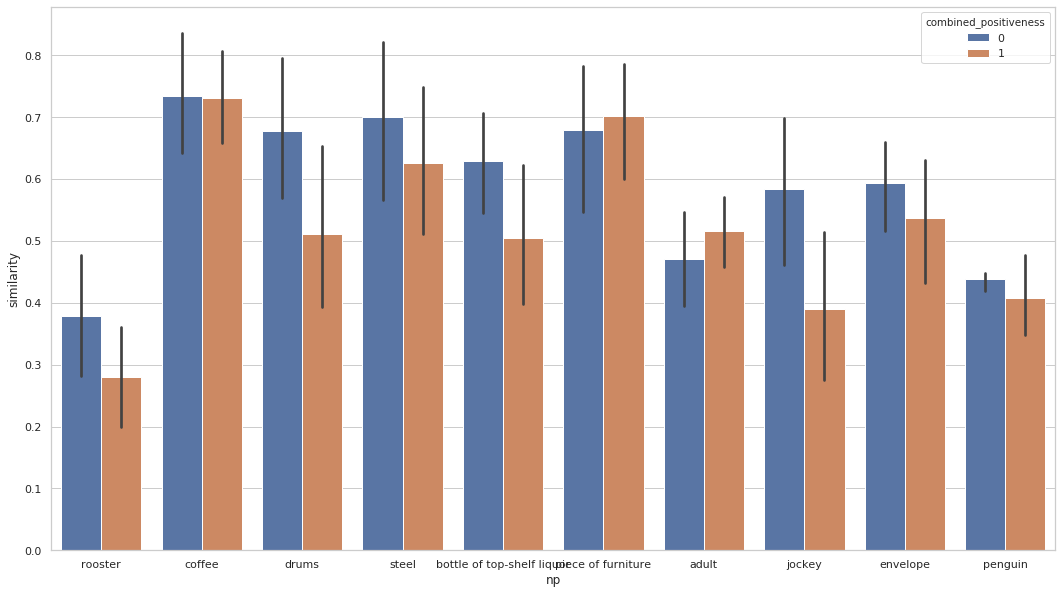

In [26]:
# Subset the data (remove metadata)
vars_to_keep = ['adj_positiveness', 'np_positiveness', 'np', 'response']
with_sim = df[vars_to_keep]

# Add similarity ratings
with_sim = append_similarity(with_sim).dropna()

# Remove neither-nor examples, Create combined positiveness -> True if np_positiveness == adj_positive
with_sim = with_sim[with_sim['np_positiveness'] != 'neither-nor']

with_sim['combined_positiveness'] = with_sim.apply(lambda row: 1 if row['adj_positiveness'] == row['np_positiveness'] else 0, axis = 1)

with_sim = with_sim.drop(columns = ['np_positiveness', 'adj_positiveness'])


# Sort and subset the 5 most common NPs
with_sim.sort_values(['combined_positiveness', 'np'])

most_common_nps = with_sim['np'].value_counts().index.tolist()[:10]
with_sim = with_sim[with_sim['np'].isin(most_common_nps)]

# Plot with/without hue
sns.set(style = 'whitegrid')

fig, ax1 = plt.subplots(1,1)
fig.set_size_inches(18, 10)

ax = sns.barplot(x="np", y="similarity", hue = 'combined_positiveness', data = with_sim, ax = ax1)

plt.show()


In [54]:
vars_to_keep = ['adj_positiveness', 'np_positiveness', 'np', 'response']
with_identity = df[vars_to_keep]

# Add similarity ratings
with_identity = append_similarity(with_identity).dropna()


with_identity['is_identical'] = with_identity['similarity'].apply(lambda sim: sim >= .85)

with_identity['is_identical'].value_counts()

close_enough = with_identity[with_identity['is_identical'] == True]

close_enough = close_enough[close_enough['similarity'] < .90]
              

close_enough

/home/jmadeano/.local/lib/python3.6/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,adj_positiveness,np_positiveness,np,response,similarity,is_identical
107,negative,positive,bottle of top-shelf liquor,bottle of liquor.,0.872495,True
221,negative,negative,piece of clothing,piece of clothes.,0.884827,True
222,positive,positive,bottle of top-shelf liquor,other bottle of liquor,0.900000,True
361,negative,negative,TV show,tv shows,0.897359,True
422,negative,negative,TV show,television shows,0.875450,True
487,positive,negative,ice cream,ice creams,0.881063,True
504,positive,negative,ice cream,ice creams,0.881063,True
513,positive,negative,TV show,tv shows,0.897359,True
564,negative,negative,TV show,tv shows,0.897359,True
581,positive,negative,ice cream,ice creams,0.881063,True


In [92]:
# Sort and subset the 5 most common NPs
subset = with_identity.drop_duplicates()['np'].tolist()[:10]
with_identity = with_identity[with_identity['np'].isin(subset)]


with_identity[with_identity['np'] == 'rooster']


# # Plot with/without hue
# sns.set(style = 'whitegrid')

# fig, ax1 = plt.subplots(1,1)
# fig.set_size_inches(18, 10)

# ax = sns.barplot(x="np", y="is_identical", data = with_identity, ax = ax1)

# plt.show()

,adj_positiveness,np_positiveness,np,response,similarity,is_identical
0,positive,positive,rooster,sounds,0.164083,False
62,negative,positive,rooster,roosters,0.498220,False
81,negative,positive,rooster,roosters,0.498220,False
103,positive,positive,rooster,cry of a roosters.,0.239923,False
113,positive,positive,rooster,sounds near by,0.112892,False
179,positive,positive,rooster,roosters,0.498220,False
204,positive,positive,rooster,roosters,0.498220,False
284,negative,positive,rooster,times of day,0.097678,False
492,negative,positive,rooster,chickens,0.343807,False
524,positive,positive,rooster,sounds animals make,0.185559,False


In [81]:
# TODO: make all lower-case, remove punctuation (periods, apostrophes, etc)